In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv("converted_portfolio_data.csv", index_col="Date", parse_dates=True)
holdings = {
    'AAPL': 0.527141, 
    'CMG': 1.943039, 
    'NVDA': 0.5050785,
    'RR.L': 16.9452464,
    'CNDX': 0.2060825,
    'JPM': 1.0610443,
    'VWRP.L': 10.6251097,
    'VUAG.L': 30.853993
}
current_values = {}
for ticker in holdings.keys():
    current_price = df[f'{ticker}_Adj Close'].iloc[-1] 
    current_values[ticker] = holdings[ticker] * current_price

In [22]:
tickers = list(holdings.keys())
returns_data = pd.DataFrame()
for ticker in tickers:
    price_series = df[f'{ticker}_Adj Close'].dropna()
    returns_data[ticker] = price_series.pct_change().dropna()
expected_returns = returns_data.mean() * 252
print('Expected Annual Returns:')
for ticker in tickers:
    print(f'{ticker}: {expected_returns[ticker]*100:.2f}%')
cov_matrix = returns_data.cov() * 252
print('Covariance Matrix (Annualized):')
print(cov_matrix.round(4))
total_portfolio_value = sum(current_values.values())
current_weights = np.array([current_values[ticker] / total_portfolio_value for ticker in tickers])
print('Current Portfolio Weights:')
for i, ticker in enumerate(tickers):
    print(f'{ticker}: {current_weights[i]*100:.2f}%')
current_portfolio_return = np.dot(current_weights, expected_returns)
current_portfolio_volatility = np.sqrt(np.dot(current_weights.T, np.dot(cov_matrix, current_weights)))
print('Current Portfolio Metrics:')
print(f'Expected Return: {current_portfolio_return*100:.2f}%')
print(f'Volatility: {current_portfolio_volatility*100:.2f}%')
print(f'Sharpe Ratio: {(current_portfolio_return - 0.02) / current_portfolio_volatility:.2f}')

Expected Annual Returns:
AAPL: 19.29%
CMG: -0.45%
NVDA: 91.34%
RR.L: 84.12%
CNDX: 22.58%
JPM: 39.28%
VWRP.L: 15.50%
VUAG.L: 17.41%
Covariance Matrix (Annualized):
          AAPL     CMG    NVDA    RR.L    CNDX     JPM  VWRP.L  VUAG.L
AAPL    0.0876  0.0333  0.0612  0.0060  0.0168  0.0268  0.0065  0.0081
CMG     0.0333  0.1131  0.0577  0.0107  0.0154  0.0290  0.0062  0.0074
NVDA    0.0612  0.0577  0.2946  0.0368  0.0464  0.0416  0.0214  0.0255
RR.L    0.0060  0.0107  0.0368  0.1185  0.0303  0.0190  0.0199  0.0215
CNDX    0.0168  0.0154  0.0464  0.0303  0.0433  0.0144  0.0226  0.0263
JPM     0.0268  0.0290  0.0416  0.0190  0.0144  0.0655  0.0103  0.0122
VWRP.L  0.0065  0.0062  0.0214  0.0199  0.0226  0.0103  0.0161  0.0181
VUAG.L  0.0081  0.0074  0.0255  0.0215  0.0263  0.0122  0.0181  0.0219
Current Portfolio Weights:
AAPL: 1.90%
CMG: 1.21%
NVDA: 1.30%
RR.L: 3.66%
CNDX: 4.17%
JPM: 4.85%
VWRP.L: 25.37%
VUAG.L: 57.54%
Current Portfolio Metrics:
Expected Return: 21.42%
Volatility: 13.96%
S

In [ ]:
# Displaying summary statistics (risk and return)
if 'expected_returns' in locals() and 'cov_matrix' in locals():
    print('Summary Statistics:')
    print('Expected Returns:')
    print(expected_returns.describe())
    print('\nVolatilities:')
    volatilities = np.sqrt(np.diag(cov_matrix)) * 100
    for i, ticker in enumerate(expected_returns.index):
        print(f'{ticker}: {volatilities[i]:.2f}%')
else:
    print('Run previous cells to define expected_returns and cov_matrix.')

Summary Statistics:
Expected Returns:
count    8.000000
mean     0.361325
std      0.336842
min     -0.004546
25%      0.169295
50%      0.209380
75%      0.504867
max      0.913408
dtype: float64

Volatilities:
AAPL: 29.59%
CMG: 33.64%
NVDA: 54.28%
RR.L: 34.42%
CNDX: 20.82%
JPM: 25.58%
VWRP.L: 12.67%
VUAG.L: 14.82%


In [ ]:
# Calculate Efficient Frontier and Optimal Portfolio

def portfolio_performance(weights, expected_returns, cov_matrix):
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility

def minimize_volatility(expected_returns, cov_matrix, target_return):
    n_assets = len(expected_returns)
    constraints = [
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': lambda x: np.dot(x, expected_returns) - target_return}
    ]
    bounds = tuple((0, 1) for _ in range(n_assets))
    initial_guess = np.array([1/n_assets] * n_assets)
    def objective(weights):
        return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    result = minimize(objective, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def maximize_sharpe_ratio(expected_returns, cov_matrix, risk_free_rate=0.02):
    n_assets = len(expected_returns)
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
    bounds = tuple((0, 1) for _ in range(n_assets))
    initial_guess = np.array([1/n_assets] * n_assets)
    def objective(weights):
        portfolio_return = np.dot(weights, expected_returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        if portfolio_volatility == 0:
            return -np.inf
        return -(portfolio_return - risk_free_rate) / portfolio_volatility
    result = minimize(objective, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

min_return = expected_returns.min()
max_return = expected_returns.max()
target_returns = np.linspace(min_return, max_return, 100)
efficient_portfolios = []
for target in target_returns:
    try:
        result = minimize_volatility(expected_returns, cov_matrix, target)
        if result.success:
            portfolio_return, portfolio_vol = portfolio_performance(result.x, expected_returns, cov_matrix)
            efficient_portfolios.append({
                'return': portfolio_return,
                'volatility': portfolio_vol,
                'weights': result.x
            })
    except:
        continue
max_sharpe_result = maximize_sharpe_ratio(expected_returns, cov_matrix)


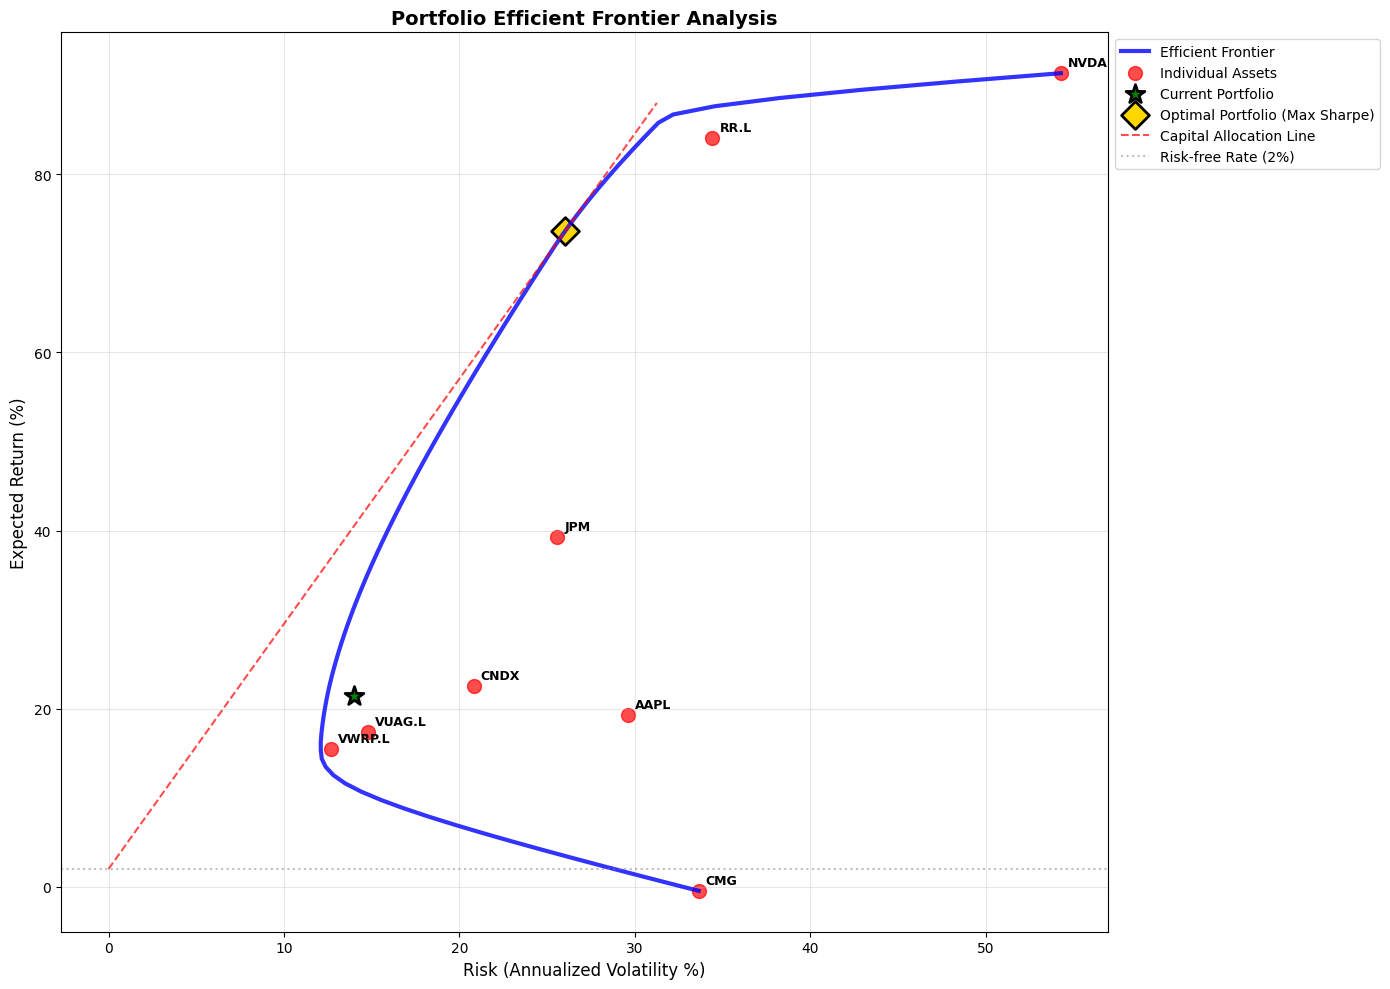

In [ ]:
plt.figure(figsize=(14, 10))

# Efficient Frontier
if "efficient_portfolios" in locals() and efficient_portfolios:
    ef_returns = np.array([p["return"] for p in efficient_portfolios]) * 100
    ef_volatilities = np.array([p["volatility"] for p in efficient_portfolios]) * 100
    plt.plot(ef_volatilities, ef_returns, "b-", linewidth=3, label="Efficient Frontier", alpha=0.8)

# Individual Assets
if "expected_returns" in locals() and "cov_matrix" in locals():
    individual_returns = expected_returns.values * 100
    individual_volatilities = np.sqrt(np.diag(cov_matrix)) * 100

    plt.scatter(individual_volatilities, individual_returns, s=100, alpha=0.7,
                c="red", marker="o", label="Individual Assets")

    for x, y, ticker in zip(individual_volatilities, individual_returns, expected_returns.index):
        plt.annotate(ticker, (x, y), xytext=(5, 5), textcoords="offset points",
                     fontsize=9, fontweight="bold")

# Current Portfolio
if "current_portfolio_volatility" in locals() and "current_portfolio_return" in locals():
    plt.scatter(current_portfolio_volatility * 100, current_portfolio_return * 100,
                s=200, c="green", marker="*", label="Current Portfolio",
                edgecolors="black", linewidth=2)

# Optimal Portfolio (Max Sharpe)
if "max_sharpe_result" in locals() and getattr(max_sharpe_result, "success", False):
    w = max_sharpe_result.x
    max_sharpe_return = w @ expected_returns
    max_sharpe_vol = np.sqrt(w.T @ cov_matrix @ w)

    plt.scatter(max_sharpe_vol * 100, max_sharpe_return * 100,
                s=200, c="gold", marker="D", label="Optimal Portfolio (Max Sharpe)",
                edgecolors="black", linewidth=2)

    # CML
    risk_free_rate = 0.02
    x_cal = np.linspace(0, max_sharpe_vol * 120, 100)  # already in %
    slope = (max_sharpe_return - risk_free_rate) / max_sharpe_vol
    y_cal = risk_free_rate * 100 + slope * x_cal
    plt.plot(x_cal, y_cal, "r--", alpha=0.7, label="Capital Allocation Line")

# Formatting
plt.axhline(y=2, color="gray", linestyle=":", alpha=0.5, label="Risk-free Rate (2%)")
plt.title("Portfolio Efficient Frontier Analysis", fontsize=14, fontweight="bold")
plt.xlabel("Risk (Annualized Volatility %)", fontsize=12)
plt.ylabel("Expected Return (%)", fontsize=12)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
